In [1]:
!pip install tifffile   

# New Section

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
import sys
import numpy as np
import pandas as pd
import os
from skimage.transform import resize
import pickle
import matplotlib
import matplotlib.pyplot as plt
from sklearn import cluster

import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold

from sklearn.utils import shuffle

from sklearn import preprocessing

import tifffile as tiff


In [4]:
############################################
## Functions
def imgToFeatVec(imgIn):
    dataMat = pickle.load(open(imgIn, "rb"))
    dataMat = dataMat[:,:,0].squeeze().flatten()
    return dataMat

In [5]:
############################################
## Hard coded paths and vars
BDIR = './Data/Prj_EuroSat/Out/Data_p20_c2-4-5-8-9'
listImg = BDIR + '/ListImages_p20_c2-4-5-8-9.csv'

SEL_LABEL = 'Forest'

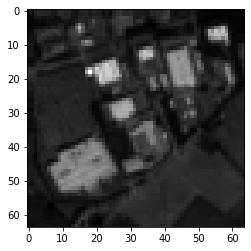

In [6]:
tmp = BDIR + '/ImagesMat/Industrial_712.p'
tmpMat = pickle.load(open(tmp, "rb"))
tmpMat.shape
plt.imshow(tmpMat[:,:,1], cmap='gray')

In [7]:
## Read data
df = pd.read_csv(listImg)
df['MatName'] = BDIR + '/ImagesMat/' + df.ImgName + '.p'
df.CType.unique()


array(['Forest', 'Highway', 'Industrial', 'Residential', 'River'],
      dtype=object)

array([[1755, 1763, 1764, 1713],
       [1755, 1763, 1764, 1713],
       [1784, 1771, 1780, 1768],
       [1772, 1802, 1796, 1791]], dtype=uint16)

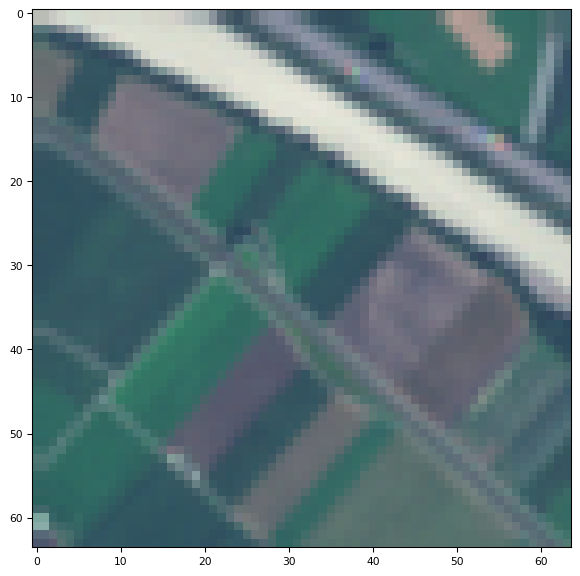

In [8]:
## Visualize an image with the label 'River'
df = pd.read_csv(listImg)
Rivers = df.loc[df['CType'] == 'River']
image1 = tiff.imread(BDIR + '/Images/' + Rivers.ImgName.iloc[0] + '.tif')
image1 = image1[:, :, [3, 2, 1]]

tiff.imshow(image1)

image2 = image1[0:4, 10:14,:]
image2[:,:,1]

In [9]:
df.CType.unique()

array(['Forest', 'Highway', 'Industrial', 'Residential', 'River'],
      dtype=object)

In [10]:
df.head()

,CNO,CType,ImgName,ImgPath
0,2,Forest,Forest_2967,../Data/sentinel_2/tif/Forest/Forest_2967.tif
1,2,Forest,Forest_845,../Data/sentinel_2/tif/Forest/Forest_845.tif
2,2,Forest,Forest_296,../Data/sentinel_2/tif/Forest/Forest_296.tif
3,2,Forest,Forest_531,../Data/sentinel_2/tif/Forest/Forest_531.tif
4,2,Forest,Forest_2394,../Data/sentinel_2/tif/Forest/Forest_2394.tif


In [11]:
df['CAT'] = 0
df.loc[df.CType==SEL_LABEL, 'CAT'] = 1
np.sum(df.CAT==0)

2100

In [12]:
df.loc[:,'MatName'] = BDIR + '/ImagesMat/' + df.ImgName + '.p'
featVecSize = imgToFeatVec(df.MatName[0]).shape[0]
dataMat = np.zeros([df.shape[0], featVecSize])

dataMat.shape


(2700, 4096)

In [13]:
for i, tmpRow in df.iterrows():
  dataMat[i,:] = imgToFeatVec(tmpRow.MatName)
labels = np.array(df.CAT)


In [14]:
### Select balanced training data
indPos = np.where(labels==1)[0]
indNeg = shuffle(np.where(labels==0)[0], random_state=42)[0:indPos.shape[0]]
indNeg
indNeg.shape


(600,)

In [15]:
indBal = shuffle(np.concatenate([indPos,indNeg]), random_state=42)

XBal = dataMat[indBal, :]
YBal = labels[indBal]

scaler = preprocessing.StandardScaler().fit(XBal)
XBalSc = scaler.transform(XBal)

X_train, X_test, y_train, y_test = train_test_split(XBalSc, YBal, train_size = 0.6, random_state=42)
np.sum(y_test == 0)

235

In [16]:
svc = SVC(kernel='linear')

print('Train size: ' + str(y_train.shape[0]))

### Training the model
print('Training the model ...')
svc.fit(X_train, y_train)

print('Applying the model ...')
yPred = svc.predict(X_test)

Train size: 720
Training the model ...
Applying the model ...


In [17]:
print( 'Accuracy: ' + str(100 * np.sum(yPred==y_test) / y_test.shape[0]))

Accuracy: 84.16666666666667
